In [61]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklego.meta.estimator_transformer import EstimatorTransformer
from scores.probability import crps_cdf
import pandas as pd
from functools import partial
from scipy import stats
from scipy import stats
from scores.probability import crps_cdf
import xarray

from src.marginal_bootstrap import *

In [62]:
import warnings

warnings.filterwarnings("ignore")

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
sklearn.set_config(enable_metadata_routing=True)

In [65]:
plt.style.use("bmh")

In [66]:
SEED = 42
SAMPLE = 1000
BOOTSTRAPS_OUTER = 1000
BOOTSTRAPS_INNER = 1000

RUNS = 1500

statistic_of_interest = partial(np.mean, axis=0)

distribution = stats.beta(0.5, 0.5)

TRUE_MEAN = distribution.stats()[0]

random_generator = np.random.default_rng(SEED)
sample = distribution.rvs(SAMPLE, random_state=random_generator)

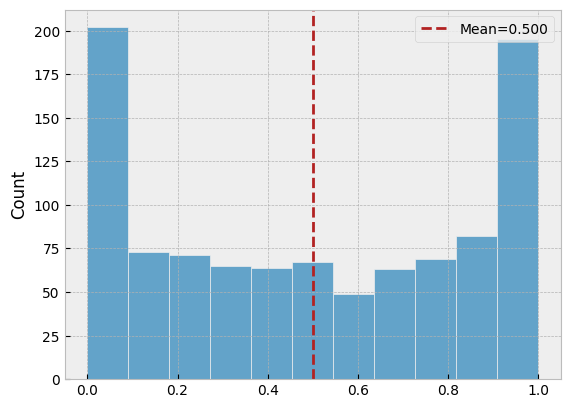

In [67]:
sns.histplot(sample)
plt.axvline(TRUE_MEAN, color="firebrick", linestyle="--", label=f"Mean={TRUE_MEAN:.3f}")
plt.legend();

In [68]:
bootstrap_methods = {
    "bayesian": bootstrap_bayesian,
    "jitter": bootstrap_with_jitter,
    "non_parametric": bootstrap_non_parametric,
    "kde": bootstrap_kde,
}

In [69]:
runs = []
for method_name, method in tqdm(
    bootstrap_methods.items(), desc="Outer Loop", position=0
):
    outer_bootstraps = bootstrap_non_parametric(
        sample, bootstrap_size=BOOTSTRAPS_OUTER, random_generator=random_generator
    )
    for inner_index, outer_bootstrap in tqdm(
        enumerate(outer_bootstraps.T),
        total=BOOTSTRAPS_OUTER,
        desc=f"Inner Loop - {method_name}",
    ):
        inner_bootstrap = method(
            outer_bootstrap,
            bootstrap_size=BOOTSTRAPS_INNER,
            random_generator=random_generator,
        )
        result = inner_index, method_name, statistic_of_interest(inner_bootstrap)
        runs.append(result)

Outer Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Inner Loop - bayesian:   0%|          | 0/1000 [00:00<?, ?it/s]

Inner Loop - jitter:   0%|          | 0/1000 [00:00<?, ?it/s]

Inner Loop - non_parametric:   0%|          | 0/1000 [00:00<?, ?it/s]

Inner Loop - kde:   0%|          | 0/1000 [00:00<?, ?it/s]

In [70]:
df = pd.DataFrame(runs, columns=["outer_index", "method", "means"]).explode("means")
df

,outer_index,method,means
0,0,bayesian,0.48559
0,0,bayesian,0.497393
0,0,bayesian,0.503135
0,0,bayesian,0.476508
0,0,bayesian,0.510018
...,...,...,...
3999,999,kde,0.524761
3999,999,kde,0.502958
3999,999,kde,0.501666
3999,999,kde,0.505155


In [71]:
summary_df = (
    df.groupby(["method", "outer_index"])
    .agg(
        lower=("means", partial(np.quantile, q=0.025)),
        upper=("means", partial(np.quantile, q=0.975)),
    )
    .assign(
        width=lambda x: x.upper - x.lower,
        midpoint=lambda x: (x.upper + x.lower) / 2,
    )
    .reset_index(drop=False)
)
summary_df

,method,outer_index,lower,upper,width,midpoint
0,bayesian,0,0.479109,0.519983,0.040874,0.499546
1,bayesian,1,0.473335,0.517967,0.044632,0.495651
2,bayesian,2,0.463790,0.506402,0.042612,0.485096
3,bayesian,3,0.463164,0.506598,0.043434,0.484881
4,bayesian,4,0.470496,0.512891,0.042396,0.491693
...,...,...,...,...,...,...
3995,non_parametric,995,0.493242,0.538502,0.045261,0.515872
3996,non_parametric,996,0.469557,0.514955,0.045398,0.492256
3997,non_parametric,997,0.469861,0.513516,0.043655,0.491688
3998,non_parametric,998,0.481356,0.525675,0.044319,0.503515


In [72]:
def coverage_ratio(true_value, lower, upper):
    return np.mean((true_value >= lower) & (true_value <= upper))

In [73]:
def regression_mwi_score(y_true, lower, upper, confidence_level: float = 0.95) -> float:
    y_pis = np.stack([lower, upper]).T[:, :, np.newaxis]
    y_pred_low = np.minimum(y_pis[:, 0, 0], y_pis[:, 1, 0])
    y_pred_up = np.maximum(y_pis[:, 0, 0], y_pis[:, 1, 0])

    width = np.sum(y_pred_up) - np.sum(y_pred_low)  # type: ignore
    error_above = np.sum((y_true - y_pred_up)[y_true > y_pred_up])
    error_below = np.sum((y_pred_low - y_true)[y_true < y_pred_low])
    total_error = error_above + error_below
    mwi = (width + total_error * 2 / (1 - confidence_level)) / len(lower)
    return mwi

In [74]:
def isd_from_kde(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    second_deriv = np.gradient(np.gradient(f_vals, dx), dx)

    isd = np.sum(second_deriv**2) * dx

    return isd


def entropy(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    f_norm = f_vals / np.sum(f_vals * dx)
    return -np.sum(f_norm * np.log(f_norm + 1e-12)) * dx

In [75]:
def cprs(true_value, samples, grid_size=20):
    x = np.linspace(min(samples), max(samples), grid_size)
    fcst_cdf = stats.norm.cdf(x, loc=0)
    fcst_array = xarray.DataArray(coords={"temperature": x}, data=fcst_cdf)
    obs_array = xarray.DataArray(true_value)
    return crps_cdf(
        fcst_array, obs_array, threshold_dim="temperature"
    ).total.values.round(3)

In [76]:
runs_df = pd.concat(
    [
        summary_df.groupby("method")
        .sample(frac=1, replace=True, random_state=boot)
        .assign(run=boot)
        for boot in range(RUNS)
    ]
)
runs_df

,method,outer_index,lower,upper,width,midpoint,run
684,bayesian,684,0.477190,0.521289,0.044099,0.499240,0
559,bayesian,559,0.473944,0.515169,0.041226,0.494556,0
629,bayesian,629,0.460791,0.506682,0.045891,0.483736,0
192,bayesian,192,0.466582,0.510618,0.044036,0.488600,0
835,bayesian,835,0.471967,0.514318,0.042351,0.493142,0
...,...,...,...,...,...,...,...
3676,non_parametric,676,0.489396,0.532874,0.043479,0.511135,1499
3126,non_parametric,126,0.470266,0.513357,0.043091,0.491812,1499
3825,non_parametric,825,0.479272,0.521603,0.042331,0.500437,1499
3561,non_parametric,561,0.471069,0.516198,0.045128,0.493633,1499


In [77]:
aggregated_metrics = {
    "coverage_ratio": lambda x: coverage_ratio(TRUE_MEAN, x.lower, x.upper),
    "mwi": lambda x: regression_mwi_score(TRUE_MEAN, x.lower, x.upper),
    "width_mean": lambda x: np.mean(x.upper - x.lower),
    "lower_std": lambda x: np.std(x.lower),
    "upper_std": lambda x: np.std(x.upper),
    # "entropy_width": lambda x: entropy(x.width),
    # "entropy_midpoint": lambda x: entropy(x.midpoint),
    "bias_midpoint": lambda x: np.mean(x.midpoint) - TRUE_MEAN,
}

grouped_runs = runs_df.groupby(["method", "run"])

aggregated_data = {}
for metric_name, metric in aggregated_metrics.items():
    aggregated_data[metric_name] = grouped_runs.apply(metric)

In [78]:
aggregated_df = pd.concat(
    [
        dataframe.to_frame("value").assign(metric=metric_name)
        for metric_name, dataframe in aggregated_data.items()
    ]
).reset_index()

In [79]:
data_metrics = {
    "log(isd)": lambda x: np.log(isd_from_kde(x.means.astype(np.float64))),
    "cprs": lambda x: cprs(TRUE_MEAN, x.means.astype(np.float64)),
    "bias_point": lambda x: np.mean(x.means) - TRUE_MEAN,
}

df_grouped = df.groupby(["method", "outer_index"])

data_aggregated_data = {}
for metric_name, metric in data_metrics.items():
    data_aggregated_data[metric_name] = df_grouped.apply(metric)

In [80]:
data_aggregated_df = pd.concat(
    [
        dataframe.to_frame("value").assign(metric=metric_name)
        for metric_name, dataframe in data_aggregated_data.items()
    ]
).reset_index()

In [81]:
study_summary_df = pd.concat([aggregated_df, data_aggregated_df]).drop(
    ["run", "outer_index"], axis=1
)
study_summary_df

,method,value,metric
0,bayesian,0.942000,coverage_ratio
1,bayesian,0.927000,coverage_ratio
2,bayesian,0.949000,coverage_ratio
3,bayesian,0.942000,coverage_ratio
4,bayesian,0.950000,coverage_ratio
...,...,...,...
11995,non_parametric,0.015550,bias_point
11996,non_parametric,-0.007427,bias_point
11997,non_parametric,-0.008984,bias_point
11998,non_parametric,0.004525,bias_point


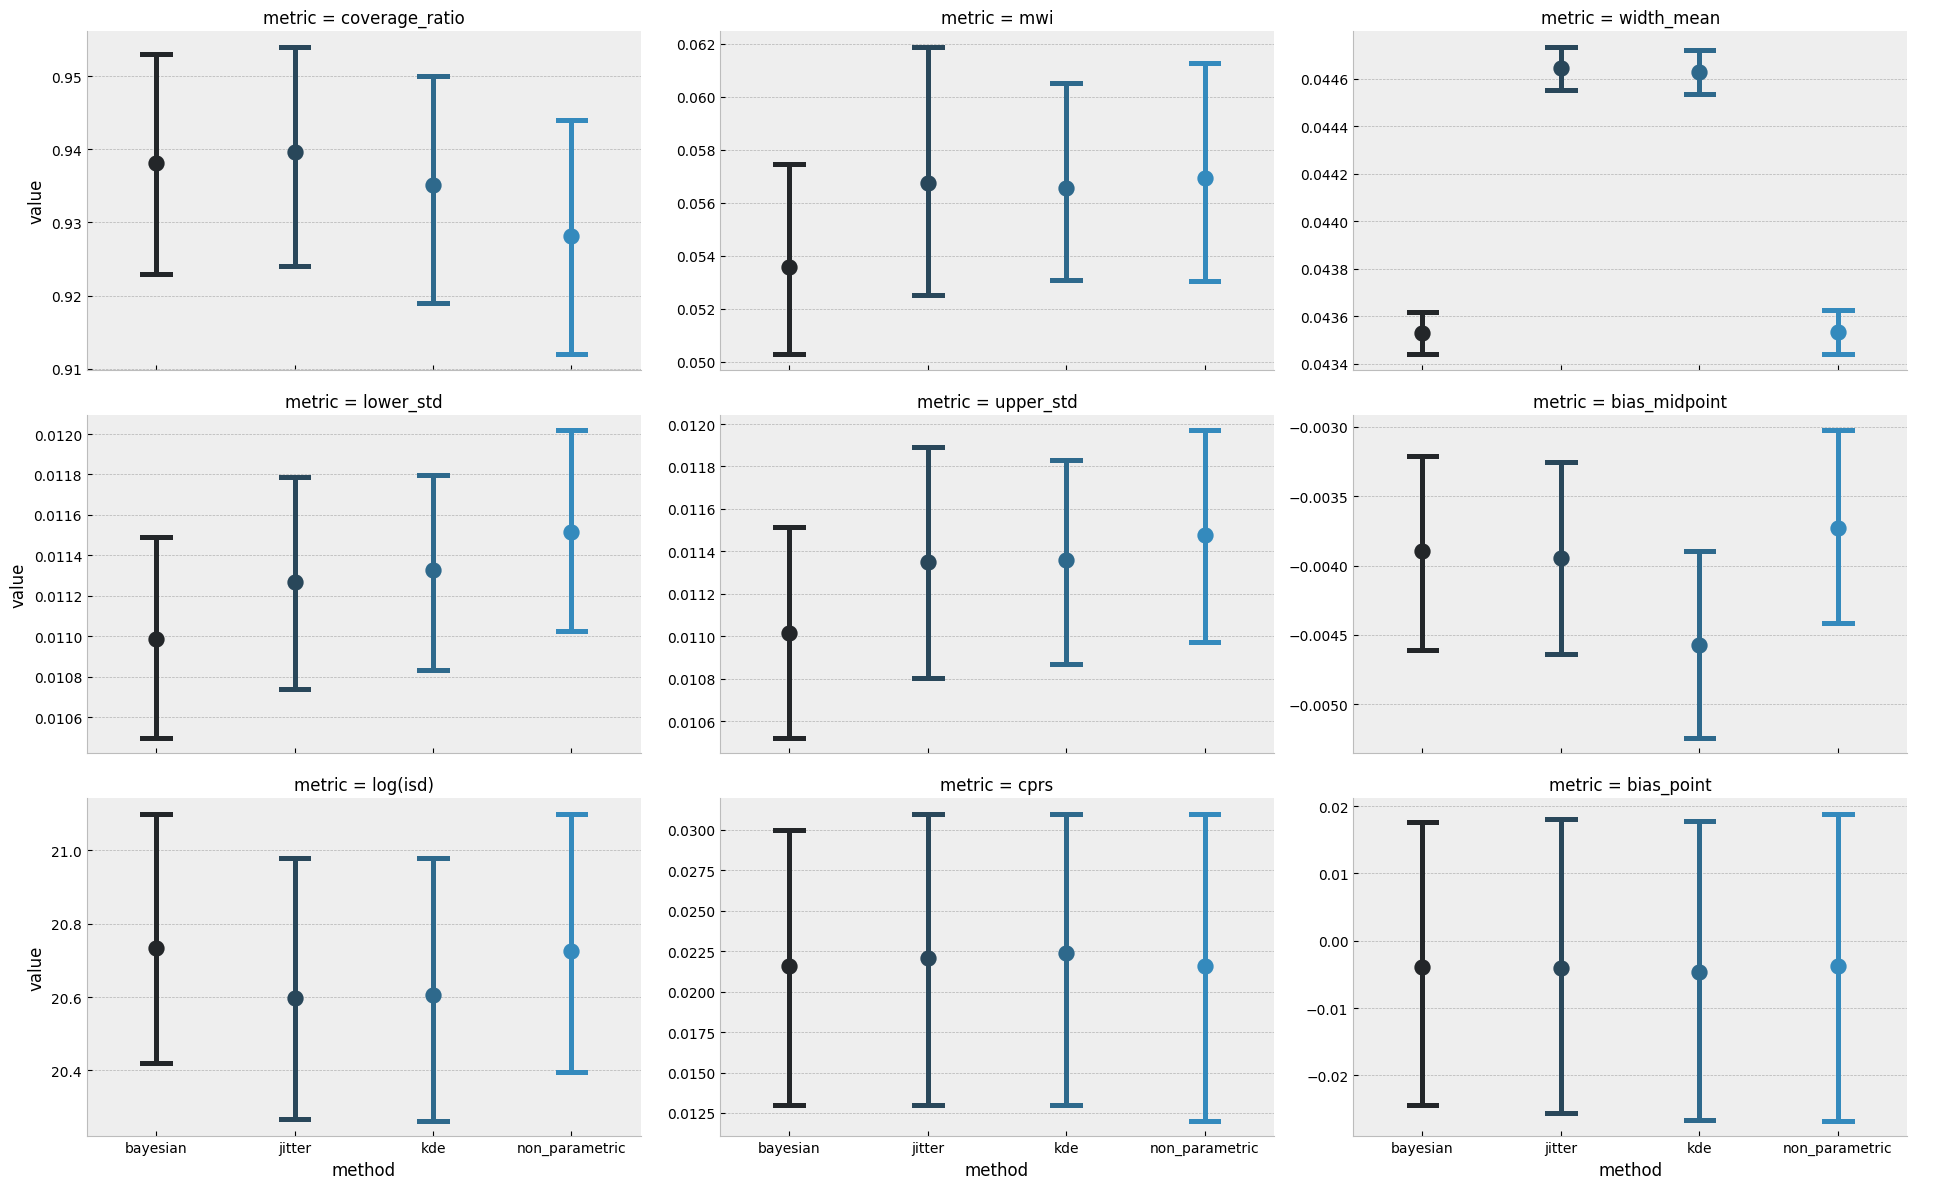

In [82]:
facet = sns.FacetGrid(
    data=study_summary_df, col="metric", height=4, aspect=1.61, sharey=False, col_wrap=3
)
facet.map_dataframe(
    sns.pointplot,
    x="method",
    hue="method",
    y="value",
    join=False,
    errorbar=("pi", 95),
    capsize=0.2,
)
facet.add_legend();

In [83]:
df

,outer_index,method,means
0,0,bayesian,0.48559
0,0,bayesian,0.497393
0,0,bayesian,0.503135
0,0,bayesian,0.476508
0,0,bayesian,0.510018
...,...,...,...
3999,999,kde,0.524761
3999,999,kde,0.502958
3999,999,kde,0.501666
3999,999,kde,0.505155


In [84]:
data_stabilization_df = df.groupby(["method"]).expanding().mean().reset_index()
data_stabilization_df["level_1"] = data_stabilization_df.groupby(["method"]).cumcount()

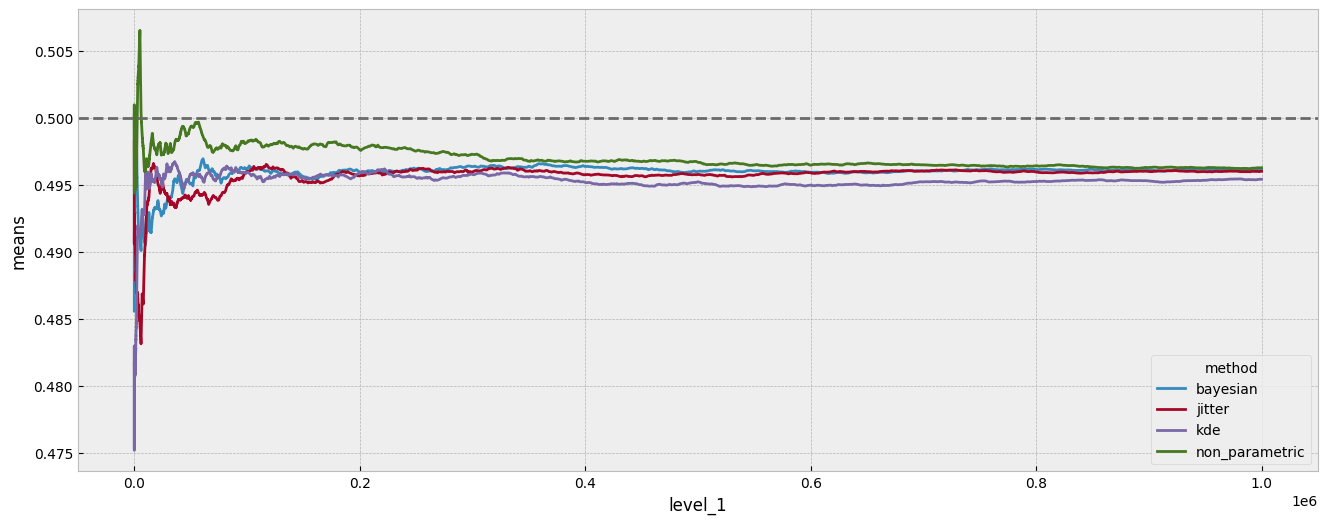

In [85]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=data_stabilization_df, x="level_1", hue="method", y="means", ax=ax)
ax.axhline(TRUE_MEAN, linestyle="--", color="dimgrey")

In [86]:
stabilization_df = (
    study_summary_df.groupby(["method", "metric"]).expanding().mean().reset_index()
)
stabilization_df["level_2"] = stabilization_df.groupby(["method", "metric"]).cumcount()

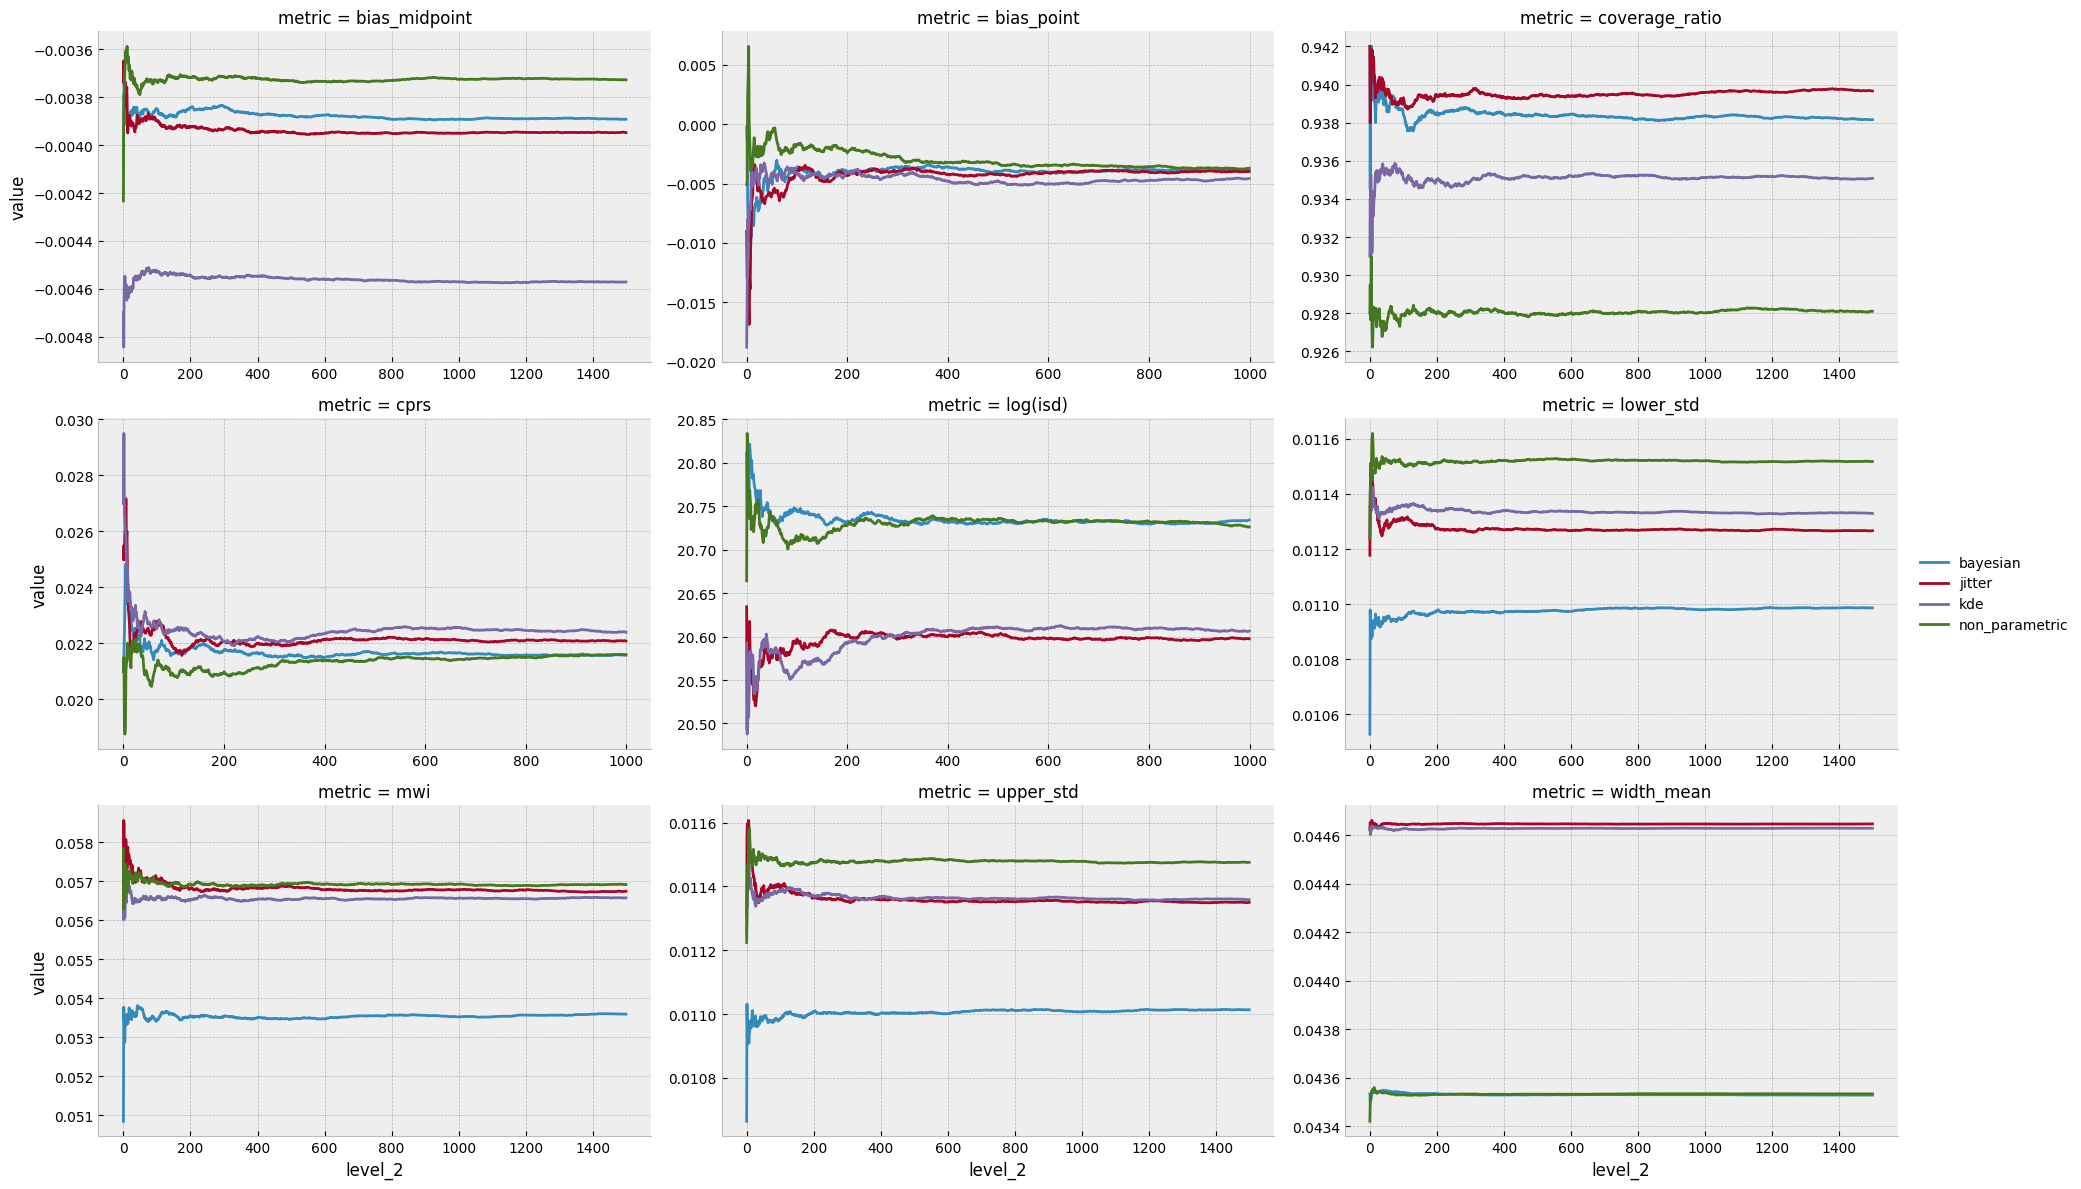

In [87]:
facet = sns.FacetGrid(
    data=stabilization_df,
    col="metric",
    height=4,
    aspect=1.61,
    sharex=False,
    sharey=False,
    col_wrap=3,
)
facet.map_dataframe(sns.lineplot, x="level_2", hue="method", y="value")
facet.add_legend();